In [2]:
from __future__ import absolute_import, division, print_function

# TensorFlow and tf.keras
import tensorflow as tf
from tensorflow import keras

print(tf.VERSION)

AUTOTUNE = tf.data.experimental.AUTOTUNE

# Helper libraries
import numpy as np
import matplotlib.pyplot as plt
plt.interactive(False)

from pathlib import *

data_root = Path('/home/charles/Downloads/dataset5/A')

image_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1/255)
image_data = image_generator.flow_from_directory(str(data_root))


1.13.1


Found 24316 images belonging to 24 classes.


In [3]:
classifier_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/classification/2" #@param {type:"string"}

import tensorflow_hub as hub
from tensorflow.keras import layers


def classifier(x):
  classifier_module = hub.Module(classifier_url)
  return classifier_module(x)
  
IMAGE_SIZE = hub.get_expected_image_size(hub.Module(classifier_url))

classifier_layer = layers.Lambda(classifier, input_shape = IMAGE_SIZE+[3])
classifier_model = tf.keras.Sequential([classifier_layer])
classifier_model.summary()

image_data = image_generator.flow_from_directory(str(data_root), target_size=IMAGE_SIZE)
for image_batch,label_batch in image_data:
  print("Image batch shape: ", image_batch.shape)
  print("Label batch shape: ", label_batch.shape)
  break

W0310 08:26:39.446169 140026920318464 __init__.py:56] Some hub symbols are not available because TensorFlow version is less than 1.14


Instructions for updating:
Colocations handled automatically by placer.


W0310 08:26:40.517847 140026920318464 deprecation.py:323] From /home/charles/TF/venv/lib/python3.7/site-packages/tensorflow/python/ops/control_flow_ops.py:3632: colocate_with (from tensorflow.python.framework.ops) is deprecated and will be removed in a future version.
Instructions for updating:
Colocations handled automatically by placer.


INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0310 08:26:49.098148 140026920318464 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda (Lambda)              (None, 1001)              0         
Total params: 0
Trainable params: 0
Non-trainable params: 0
_________________________________________________________________


Found 24316 images belonging to 24 classes.


Image batch shape:  (32, 224, 224, 3)
Label batch shape:  (32, 24)


In [4]:
import tensorflow.keras.backend as K
sess = K.get_session()
init = tf.global_variables_initializer()

sess.run(init)

In [5]:
feature_extractor_url = "https://tfhub.dev/google/imagenet/mobilenet_v2_100_224/feature_vector/2" #@param {type:"string"}

def feature_extractor(x):
  feature_extractor_module = hub.Module(feature_extractor_url)
  return feature_extractor_module(x)

IMAGE_SIZE = hub.get_expected_image_size(hub.Module(feature_extractor_url))

features_extractor_layer = layers.Lambda(feature_extractor, input_shape=IMAGE_SIZE+[3])
features_extractor_layer.trainable = False


In [7]:
model = tf.keras.Sequential([
  features_extractor_layer,
  layers.Dense(image_data.num_classes, activation='softmax')
])
model.summary()

INFO:tensorflow:Saver not created because there are no variables in the graph to restore


I0310 00:33:39.915234 140718751245824 saver.py:1483] Saver not created because there are no variables in the graph to restore


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lambda_1 (Lambda)            (None, 1280)              0         
_________________________________________________________________
dense (Dense)                (None, 24)                30744     
Total params: 30,744
Trainable params: 30,744
Non-trainable params: 0
_________________________________________________________________


In [8]:
init = tf.global_variables_initializer()
sess.run(init)
result = model.predict(image_batch)
result.shape

(32, 24)

In [14]:
from tensorflow.keras import optimizers
model.compile(
  optimizer=keras.optimizers.Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=None, decay=0.0, amsgrad=False),
  loss='categorical_crossentropy',
  metrics=['accuracy'])

class CollectBatchStats(tf.keras.callbacks.Callback):
  def __init__(self):
    self.batch_losses = []
    self.batch_acc = []
    
  def on_batch_end(self, batch, logs=None):
    self.batch_losses.append(logs['loss'])
    self.batch_acc.append(logs['acc'])

steps_per_epoch = image_data.samples//image_data.batch_size
batch_stats = CollectBatchStats()
model.fit((item for item in image_data), epochs=1, 
                    steps_per_epoch=steps_per_epoch,
                    callbacks = [batch_stats])


Instructions for updating:
Use tf.cast instead.


W0310 00:34:30.390438 140718751245824 deprecation.py:323] From /home/charles/TF/venv/lib/python3.7/site-packages/tensorflow/python/ops/math_ops.py:3066: to_int32 (from tensorflow.python.ops.math_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.cast instead.


  1/392 [..............................] - ETA: 10:45 - loss: 3.5417 - acc: 0.0312

  2/392 [..............................] - ETA: 8:22 - loss: 3.7511 - acc: 0.0469 

  3/392 [..............................] - ETA: 7:38 - loss: 3.5712 - acc: 0.0938

  4/392 [..............................] - ETA: 7:11 - loss: 3.6185 - acc: 0.1016

  5/392 [..............................] - ETA: 6:54 - loss: 3.6133 - acc: 0.0875

  6/392 [..............................] - ETA: 6:44 - loss: 3.5804 - acc: 0.0781

  7/392 [..............................] - ETA: 6:37 - loss: 3.4912 - acc: 0.0804

  8/392 [..............................] - ETA: 6:32 - loss: 3.4201 - acc: 0.0898

  9/392 [..............................] - ETA: 6:26 - loss: 3.3895 - acc: 0.1007

 10/392 [..............................] - ETA: 6:21 - loss: 3.3626 - acc: 0.1094

 11/392 [..............................] - ETA: 6:17 - loss: 3.3459 - acc: 0.1051

 12/392 [..............................] - ETA: 6:14 - loss: 3.2752 - acc: 0.1172

 13/392 [..............................] - ETA: 6:11 - loss: 3.2073 - acc: 0.1346

 14/392 [>.............................] - ETA: 6:09 - loss: 3.1789 - acc: 0.1339

 15/392 [>.............................] - ETA: 6:07 - loss: 3.1392 - acc: 0.1521

 16/392 [>.............................] - ETA: 6:04 - loss: 3.0933 - acc: 0.1621

 17/392 [>.............................] - ETA: 6:03 - loss: 3.0621 - acc: 0.1673

 18/392 [>.............................] - ETA: 6:02 - loss: 3.0412 - acc: 0.1719

 19/392 [>.............................] - ETA: 6:00 - loss: 3.0038 - acc: 0.1793

 20/392 [>.............................] - ETA: 5:58 - loss: 2.9737 - acc: 0.1828

 21/392 [>.............................] - ETA: 5:56 - loss: 2.9344 - acc: 0.1935

 22/392 [>.............................] - ETA: 5:54 - loss: 2.8928 - acc: 0.2060

 23/392 [>.............................] - ETA: 5:53 - loss: 2.8661 - acc: 0.2120

 24/392 [>.............................] - ETA: 5:51 - loss: 2.8244 - acc: 0.2227

 25/392 [>.............................] - ETA: 5:52 - loss: 2.7976 - acc: 0.2313

 26/392 [>.............................] - ETA: 5:50 - loss: 2.7585 - acc: 0.2464

 27/392 [=>............................] - ETA: 5:49 - loss: 2.7335 - acc: 0.2523

 28/392 [=>............................] - ETA: 5:47 - loss: 2.7042 - acc: 0.2623

 29/392 [=>............................] - ETA: 5:46 - loss: 2.6802 - acc: 0.2672

 30/392 [=>............................] - ETA: 5:45 - loss: 2.6526 - acc: 0.2750

 31/392 [=>............................] - ETA: 5:43 - loss: 2.6250 - acc: 0.2823

 32/392 [=>............................] - ETA: 5:42 - loss: 2.5928 - acc: 0.2900

 33/392 [=>............................] - ETA: 5:42 - loss: 2.5602 - acc: 0.2983

 34/392 [=>............................] - ETA: 5:41 - loss: 2.5307 - acc: 0.3061

 35/392 [=>............................] - ETA: 5:40 - loss: 2.5130 - acc: 0.3080

 36/392 [=>............................] - ETA: 5:39 - loss: 2.4899 - acc: 0.3177

 37/392 [=>............................] - ETA: 5:37 - loss: 2.4676 - acc: 0.3252

 38/392 [=>............................] - ETA: 5:36 - loss: 2.4466 - acc: 0.3273

 39/392 [=>............................] - ETA: 5:35 - loss: 2.4119 - acc: 0.3389

 40/392 [==>...........................] - ETA: 5:34 - loss: 2.3867 - acc: 0.3477

 41/392 [==>...........................] - ETA: 5:33 - loss: 2.3658 - acc: 0.3552

 42/392 [==>...........................] - ETA: 5:33 - loss: 2.3461 - acc: 0.3609

 43/392 [==>...........................] - ETA: 5:32 - loss: 2.3169 - acc: 0.3699

 44/392 [==>...........................] - ETA: 5:32 - loss: 2.2988 - acc: 0.3736

 45/392 [==>...........................] - ETA: 5:31 - loss: 2.2780 - acc: 0.3785

 46/392 [==>...........................] - ETA: 5:31 - loss: 2.2659 - acc: 0.3818

 47/392 [==>...........................] - ETA: 5:30 - loss: 2.2431 - acc: 0.3870

 48/392 [==>...........................] - ETA: 5:30 - loss: 2.2292 - acc: 0.3913

 49/392 [==>...........................] - ETA: 5:29 - loss: 2.2071 - acc: 0.3980

 50/392 [==>...........................] - ETA: 5:28 - loss: 2.1929 - acc: 0.4019

 51/392 [==>...........................] - ETA: 5:27 - loss: 2.1747 - acc: 0.4081

 52/392 [==>...........................] - ETA: 5:27 - loss: 2.1562 - acc: 0.4129

 53/392 [===>..........................] - ETA: 5:26 - loss: 2.1333 - acc: 0.4192

 54/392 [===>..........................] - ETA: 5:25 - loss: 2.1113 - acc: 0.4242

 55/392 [===>..........................] - ETA: 5:25 - loss: 2.0981 - acc: 0.4290

 56/392 [===>..........................] - ETA: 5:24 - loss: 2.0789 - acc: 0.4336

 57/392 [===>..........................] - ETA: 5:23 - loss: 2.0602 - acc: 0.4402

 58/392 [===>..........................] - ETA: 5:23 - loss: 2.0414 - acc: 0.4450

 59/392 [===>..........................] - ETA: 5:22 - loss: 2.0263 - acc: 0.4486

 60/392 [===>..........................] - ETA: 5:21 - loss: 2.0076 - acc: 0.4557

 61/392 [===>..........................] - ETA: 5:20 - loss: 1.9908 - acc: 0.4611

 62/392 [===>..........................] - ETA: 5:19 - loss: 1.9761 - acc: 0.4662

 63/392 [===>..........................] - ETA: 5:19 - loss: 1.9599 - acc: 0.4707

 64/392 [===>..........................] - ETA: 5:18 - loss: 1.9423 - acc: 0.4766

 65/392 [===>..........................] - ETA: 5:17 - loss: 1.9343 - acc: 0.4788

 66/392 [====>.........................] - ETA: 5:16 - loss: 1.9207 - acc: 0.4825

 67/392 [====>.........................] - ETA: 5:15 - loss: 1.9076 - acc: 0.4855

 68/392 [====>.........................] - ETA: 5:14 - loss: 1.8926 - acc: 0.4894

 69/392 [====>.........................] - ETA: 5:13 - loss: 1.8782 - acc: 0.4932

 70/392 [====>.........................] - ETA: 5:12 - loss: 1.8623 - acc: 0.4982

 71/392 [====>.........................] - ETA: 5:11 - loss: 1.8499 - acc: 0.5022

 72/392 [====>.........................] - ETA: 5:11 - loss: 1.8343 - acc: 0.5061

 73/392 [====>.........................] - ETA: 5:10 - loss: 1.8202 - acc: 0.5107

 74/392 [====>.........................] - ETA: 5:09 - loss: 1.8055 - acc: 0.5144

 75/392 [====>.........................] - ETA: 5:08 - loss: 1.7953 - acc: 0.5175

 76/392 [====>.........................] - ETA: 5:07 - loss: 1.7815 - acc: 0.5226

 77/392 [====>.........................] - ETA: 5:06 - loss: 1.7705 - acc: 0.5260

 78/392 [====>.........................] - ETA: 5:06 - loss: 1.7570 - acc: 0.5304

 79/392 [=====>........................] - ETA: 5:05 - loss: 1.7457 - acc: 0.5332

 80/392 [=====>........................] - ETA: 5:04 - loss: 1.7358 - acc: 0.5359

 81/392 [=====>........................] - ETA: 5:03 - loss: 1.7241 - acc: 0.5390

 82/392 [=====>........................] - ETA: 5:02 - loss: 1.7155 - acc: 0.5415

 83/392 [=====>........................] - ETA: 5:01 - loss: 1.7023 - acc: 0.5459

 84/392 [=====>........................] - ETA: 5:00 - loss: 1.6929 - acc: 0.5487

 85/392 [=====>........................] - ETA: 4:59 - loss: 1.6822 - acc: 0.5526

 86/392 [=====>........................] - ETA: 4:58 - loss: 1.6721 - acc: 0.5560

 87/392 [=====>........................] - ETA: 4:58 - loss: 1.6636 - acc: 0.5578

 88/392 [=====>........................] - ETA: 4:57 - loss: 1.6517 - acc: 0.5607

 89/392 [=====>........................] - ETA: 4:56 - loss: 1.6392 - acc: 0.5639

 90/392 [=====>........................] - ETA: 4:55 - loss: 1.6286 - acc: 0.5667

 91/392 [=====>........................] - ETA: 4:54 - loss: 1.6190 - acc: 0.5694

 92/392 [======>.......................] - ETA: 4:53 - loss: 1.6086 - acc: 0.5720

 93/392 [======>.......................] - ETA: 4:52 - loss: 1.6012 - acc: 0.5739

 94/392 [======>.......................] - ETA: 4:51 - loss: 1.5911 - acc: 0.5765

 95/392 [======>.......................] - ETA: 4:51 - loss: 1.5822 - acc: 0.5789

 96/392 [======>.......................] - ETA: 4:50 - loss: 1.5735 - acc: 0.5820

 97/392 [======>.......................] - ETA: 4:49 - loss: 1.5652 - acc: 0.5841

 98/392 [======>.......................] - ETA: 4:48 - loss: 1.5568 - acc: 0.5867

 99/392 [======>.......................] - ETA: 4:47 - loss: 1.5478 - acc: 0.5896

100/392 [======>.......................] - ETA: 4:46 - loss: 1.5408 - acc: 0.5909

101/392 [======>.......................] - ETA: 4:45 - loss: 1.5304 - acc: 0.5941

102/392 [======>.......................] - ETA: 4:44 - loss: 1.5226 - acc: 0.5962

103/392 [======>.......................] - ETA: 4:43 - loss: 1.5135 - acc: 0.5989

104/392 [======>.......................] - ETA: 4:42 - loss: 1.5069 - acc: 0.6001

105/392 [=======>......................] - ETA: 4:41 - loss: 1.4972 - acc: 0.6033

106/392 [=======>......................] - ETA: 4:40 - loss: 1.4877 - acc: 0.6058

107/392 [=======>......................] - ETA: 4:40 - loss: 1.4800 - acc: 0.6081

108/392 [=======>......................] - ETA: 4:39 - loss: 1.4714 - acc: 0.6108

109/392 [=======>......................] - ETA: 4:38 - loss: 1.4667 - acc: 0.6118

110/392 [=======>......................] - ETA: 4:37 - loss: 1.4586 - acc: 0.6142

111/392 [=======>......................] - ETA: 4:36 - loss: 1.4534 - acc: 0.6154

112/392 [=======>......................] - ETA: 4:35 - loss: 1.4489 - acc: 0.6169

113/392 [=======>......................] - ETA: 4:34 - loss: 1.4417 - acc: 0.6186

114/392 [=======>......................] - ETA: 4:33 - loss: 1.4338 - acc: 0.6206

115/392 [=======>......................] - ETA: 4:32 - loss: 1.4276 - acc: 0.6223

116/392 [=======>......................] - ETA: 4:31 - loss: 1.4204 - acc: 0.6245

117/392 [=======>......................] - ETA: 4:30 - loss: 1.4136 - acc: 0.6263

118/392 [========>.....................] - ETA: 4:29 - loss: 1.4052 - acc: 0.6292

119/392 [========>.....................] - ETA: 4:28 - loss: 1.3975 - acc: 0.6316

120/392 [========>.....................] - ETA: 4:27 - loss: 1.3913 - acc: 0.6328

121/392 [========>.....................] - ETA: 4:26 - loss: 1.3852 - acc: 0.6343

122/392 [========>.....................] - ETA: 4:25 - loss: 1.3797 - acc: 0.6363

123/392 [========>.....................] - ETA: 4:25 - loss: 1.3740 - acc: 0.6380

124/392 [========>.....................] - ETA: 4:24 - loss: 1.3688 - acc: 0.6396

125/392 [========>.....................] - ETA: 4:23 - loss: 1.3628 - acc: 0.6413

126/392 [========>.....................] - ETA: 4:22 - loss: 1.3574 - acc: 0.6426

127/392 [========>.....................] - ETA: 4:21 - loss: 1.3504 - acc: 0.6444

128/392 [========>.....................] - ETA: 4:20 - loss: 1.3445 - acc: 0.6458

129/392 [========>.....................] - ETA: 4:19 - loss: 1.3387 - acc: 0.6473

130/392 [========>.....................] - ETA: 4:18 - loss: 1.3314 - acc: 0.6495

131/392 [=========>....................] - ETA: 4:17 - loss: 1.3237 - acc: 0.6522

132/392 [=========>....................] - ETA: 4:16 - loss: 1.3180 - acc: 0.6541

133/392 [=========>....................] - ETA: 4:15 - loss: 1.3127 - acc: 0.6553

134/392 [=========>....................] - ETA: 4:14 - loss: 1.3070 - acc: 0.6565

135/392 [=========>....................] - ETA: 4:13 - loss: 1.3013 - acc: 0.6583

136/392 [=========>....................] - ETA: 4:12 - loss: 1.2958 - acc: 0.6599

137/392 [=========>....................] - ETA: 4:11 - loss: 1.2895 - acc: 0.6620

138/392 [=========>....................] - ETA: 4:10 - loss: 1.2845 - acc: 0.6635

139/392 [=========>....................] - ETA: 4:09 - loss: 1.2776 - acc: 0.6657

140/392 [=========>....................] - ETA: 4:09 - loss: 1.2733 - acc: 0.6663

141/392 [=========>....................] - ETA: 4:08 - loss: 1.2674 - acc: 0.6684

142/392 [=========>....................] - ETA: 4:07 - loss: 1.2619 - acc: 0.6701

143/392 [=========>....................] - ETA: 4:06 - loss: 1.2563 - acc: 0.6722

144/392 [==========>...................] - ETA: 4:05 - loss: 1.2504 - acc: 0.6743

145/392 [==========>...................] - ETA: 4:04 - loss: 1.2471 - acc: 0.6756

146/392 [==========>...................] - ETA: 4:03 - loss: 1.2429 - acc: 0.6764

147/392 [==========>...................] - ETA: 4:02 - loss: 1.2379 - acc: 0.6777

148/392 [==========>...................] - ETA: 4:01 - loss: 1.2340 - acc: 0.6788

149/392 [==========>...................] - ETA: 4:00 - loss: 1.2283 - acc: 0.6802

150/392 [==========>...................] - ETA: 3:59 - loss: 1.2229 - acc: 0.6821

151/392 [==========>...................] - ETA: 3:58 - loss: 1.2191 - acc: 0.6829

152/392 [==========>...................] - ETA: 3:57 - loss: 1.2134 - acc: 0.6842

153/392 [==========>...................] - ETA: 3:56 - loss: 1.2083 - acc: 0.6857

154/392 [==========>...................] - ETA: 3:55 - loss: 1.2042 - acc: 0.6873

155/392 [==========>...................] - ETA: 3:54 - loss: 1.1990 - acc: 0.6889

156/392 [==========>...................] - ETA: 3:53 - loss: 1.1946 - acc: 0.6903

157/392 [===========>..................] - ETA: 3:52 - loss: 1.1892 - acc: 0.6921

158/392 [===========>..................] - ETA: 3:51 - loss: 1.1846 - acc: 0.6932

159/392 [===========>..................] - ETA: 3:50 - loss: 1.1803 - acc: 0.6944

160/392 [===========>..................] - ETA: 3:49 - loss: 1.1751 - acc: 0.6957

161/392 [===========>..................] - ETA: 3:48 - loss: 1.1712 - acc: 0.6970

162/392 [===========>..................] - ETA: 3:47 - loss: 1.1679 - acc: 0.6981

163/392 [===========>..................] - ETA: 3:46 - loss: 1.1638 - acc: 0.6994

164/392 [===========>..................] - ETA: 3:45 - loss: 1.1597 - acc: 0.7008

165/392 [===========>..................] - ETA: 3:44 - loss: 1.1559 - acc: 0.7019

166/392 [===========>..................] - ETA: 3:43 - loss: 1.1519 - acc: 0.7031

167/392 [===========>..................] - ETA: 3:42 - loss: 1.1472 - acc: 0.7045

168/392 [===========>..................] - ETA: 3:41 - loss: 1.1429 - acc: 0.7057

169/392 [===========>..................] - ETA: 3:40 - loss: 1.1393 - acc: 0.7067

170/392 [============>.................] - ETA: 3:39 - loss: 1.1357 - acc: 0.7077

171/392 [============>.................] - ETA: 3:38 - loss: 1.1310 - acc: 0.7091

172/392 [============>.................] - ETA: 3:37 - loss: 1.1264 - acc: 0.7106

173/392 [============>.................] - ETA: 3:36 - loss: 1.1227 - acc: 0.7113

174/392 [============>.................] - ETA: 3:35 - loss: 1.1187 - acc: 0.7125

175/392 [============>.................] - ETA: 3:35 - loss: 1.1140 - acc: 0.7138

176/392 [============>.................] - ETA: 3:34 - loss: 1.1100 - acc: 0.7152

177/392 [============>.................] - ETA: 3:33 - loss: 1.1053 - acc: 0.7166

178/392 [============>.................] - ETA: 3:32 - loss: 1.1012 - acc: 0.7177

179/392 [============>.................] - ETA: 3:31 - loss: 1.0982 - acc: 0.7186

180/392 [============>.................] - ETA: 3:30 - loss: 1.0951 - acc: 0.7194

181/392 [============>.................] - ETA: 3:29 - loss: 1.0915 - acc: 0.7206

182/392 [============>.................] - ETA: 3:28 - loss: 1.0872 - acc: 0.7218

183/392 [=============>................] - ETA: 3:27 - loss: 1.0840 - acc: 0.7228

184/392 [=============>................] - ETA: 3:26 - loss: 1.0797 - acc: 0.7244

185/392 [=============>................] - ETA: 3:25 - loss: 1.0766 - acc: 0.7252

186/392 [=============>................] - ETA: 3:24 - loss: 1.0742 - acc: 0.7256

187/392 [=============>................] - ETA: 3:23 - loss: 1.0706 - acc: 0.7268

188/392 [=============>................] - ETA: 3:22 - loss: 1.0674 - acc: 0.7279

189/392 [=============>................] - ETA: 3:21 - loss: 1.0646 - acc: 0.7283

190/392 [=============>................] - ETA: 3:20 - loss: 1.0614 - acc: 0.7293

191/392 [=============>................] - ETA: 3:19 - loss: 1.0586 - acc: 0.7297

192/392 [=============>................] - ETA: 3:18 - loss: 1.0551 - acc: 0.7301

193/392 [=============>................] - ETA: 3:17 - loss: 1.0508 - acc: 0.7314

194/392 [=============>................] - ETA: 3:16 - loss: 1.0481 - acc: 0.7318

195/392 [=============>................] - ETA: 3:15 - loss: 1.0455 - acc: 0.7324

196/392 [==============>...............] - ETA: 3:14 - loss: 1.0436 - acc: 0.7326

197/392 [==============>...............] - ETA: 3:13 - loss: 1.0400 - acc: 0.7338

198/392 [==============>...............] - ETA: 3:12 - loss: 1.0367 - acc: 0.7347

199/392 [==============>...............] - ETA: 3:11 - loss: 1.0326 - acc: 0.7359

200/392 [==============>...............] - ETA: 3:10 - loss: 1.0296 - acc: 0.7366

201/392 [==============>...............] - ETA: 3:09 - loss: 1.0275 - acc: 0.7374

202/392 [==============>...............] - ETA: 3:08 - loss: 1.0245 - acc: 0.7384

203/392 [==============>...............] - ETA: 3:07 - loss: 1.0224 - acc: 0.7388

204/392 [==============>...............] - ETA: 3:06 - loss: 1.0199 - acc: 0.7393

205/392 [==============>...............] - ETA: 3:05 - loss: 1.0163 - acc: 0.7404

206/392 [==============>...............] - ETA: 3:04 - loss: 1.0139 - acc: 0.7406

207/392 [==============>...............] - ETA: 3:03 - loss: 1.0106 - acc: 0.7417

208/392 [==============>...............] - ETA: 3:02 - loss: 1.0073 - acc: 0.7426

209/392 [==============>...............] - ETA: 3:01 - loss: 1.0046 - acc: 0.7433

210/392 [===============>..............] - ETA: 3:00 - loss: 1.0021 - acc: 0.7439

211/392 [===============>..............] - ETA: 2:59 - loss: 1.0004 - acc: 0.7445

212/392 [===============>..............] - ETA: 2:58 - loss: 0.9976 - acc: 0.7453

213/392 [===============>..............] - ETA: 2:57 - loss: 0.9969 - acc: 0.7449

214/392 [===============>..............] - ETA: 2:56 - loss: 0.9938 - acc: 0.7458

215/392 [===============>..............] - ETA: 2:55 - loss: 0.9906 - acc: 0.7468

216/392 [===============>..............] - ETA: 2:54 - loss: 0.9878 - acc: 0.7475

217/392 [===============>..............] - ETA: 2:53 - loss: 0.9849 - acc: 0.7481

218/392 [===============>..............] - ETA: 2:52 - loss: 0.9815 - acc: 0.7491

219/392 [===============>..............] - ETA: 2:52 - loss: 0.9782 - acc: 0.7503

220/392 [===============>..............] - ETA: 2:51 - loss: 0.9748 - acc: 0.7513

221/392 [===============>..............] - ETA: 2:50 - loss: 0.9719 - acc: 0.7518

222/392 [===============>..............] - ETA: 2:49 - loss: 0.9691 - acc: 0.7528

223/392 [================>.............] - ETA: 2:48 - loss: 0.9657 - acc: 0.7539

224/392 [================>.............] - ETA: 2:47 - loss: 0.9623 - acc: 0.7547

225/392 [================>.............] - ETA: 2:46 - loss: 0.9599 - acc: 0.7557

226/392 [================>.............] - ETA: 2:45 - loss: 0.9579 - acc: 0.7559

227/392 [================>.............] - ETA: 2:44 - loss: 0.9551 - acc: 0.7566

228/392 [================>.............] - ETA: 2:43 - loss: 0.9531 - acc: 0.7571

229/392 [================>.............] - ETA: 2:42 - loss: 0.9509 - acc: 0.7575

230/392 [================>.............] - ETA: 2:41 - loss: 0.9492 - acc: 0.7579

231/392 [================>.............] - ETA: 2:40 - loss: 0.9466 - acc: 0.7587

232/392 [================>.............] - ETA: 2:39 - loss: 0.9446 - acc: 0.7588

233/392 [================>.............] - ETA: 2:38 - loss: 0.9417 - acc: 0.7595

234/392 [================>.............] - ETA: 2:37 - loss: 0.9405 - acc: 0.7599

235/392 [================>.............] - ETA: 2:36 - loss: 0.9376 - acc: 0.7608

236/392 [=================>............] - ETA: 2:35 - loss: 0.9350 - acc: 0.7617

237/392 [=================>............] - ETA: 2:34 - loss: 0.9338 - acc: 0.7619

238/392 [=================>............] - ETA: 2:33 - loss: 0.9321 - acc: 0.7621

239/392 [=================>............] - ETA: 2:32 - loss: 0.9299 - acc: 0.7628

240/392 [=================>............] - ETA: 2:31 - loss: 0.9269 - acc: 0.7638

241/392 [=================>............] - ETA: 2:30 - loss: 0.9241 - acc: 0.7647

242/392 [=================>............] - ETA: 2:29 - loss: 0.9210 - acc: 0.7656

243/392 [=================>............] - ETA: 2:28 - loss: 0.9185 - acc: 0.7662

244/392 [=================>............] - ETA: 2:27 - loss: 0.9167 - acc: 0.7666

245/392 [=================>............] - ETA: 2:26 - loss: 0.9141 - acc: 0.7672

246/392 [=================>............] - ETA: 2:25 - loss: 0.9123 - acc: 0.7677

247/392 [=================>............] - ETA: 2:24 - loss: 0.9103 - acc: 0.7682

248/392 [=================>............] - ETA: 2:23 - loss: 0.9082 - acc: 0.7686

249/392 [==================>...........] - ETA: 2:22 - loss: 0.9055 - acc: 0.7696

250/392 [==================>...........] - ETA: 2:21 - loss: 0.9034 - acc: 0.7703

251/392 [==================>...........] - ETA: 2:20 - loss: 0.9006 - acc: 0.7710

252/392 [==================>...........] - ETA: 2:19 - loss: 0.8986 - acc: 0.7717

253/392 [==================>...........] - ETA: 2:18 - loss: 0.8965 - acc: 0.7720

254/392 [==================>...........] - ETA: 2:17 - loss: 0.8945 - acc: 0.7725

255/392 [==================>...........] - ETA: 2:16 - loss: 0.8930 - acc: 0.7729

256/392 [==================>...........] - ETA: 2:15 - loss: 0.8909 - acc: 0.7736

257/392 [==================>...........] - ETA: 2:14 - loss: 0.8890 - acc: 0.7738

258/392 [==================>...........] - ETA: 2:13 - loss: 0.8870 - acc: 0.7742

259/392 [==================>...........] - ETA: 2:12 - loss: 0.8848 - acc: 0.7750

260/392 [==================>...........] - ETA: 2:11 - loss: 0.8833 - acc: 0.7754

261/392 [==================>...........] - ETA: 2:10 - loss: 0.8814 - acc: 0.7760

262/392 [===================>..........] - ETA: 2:09 - loss: 0.8788 - acc: 0.7767

263/392 [===================>..........] - ETA: 2:08 - loss: 0.8766 - acc: 0.7776

264/392 [===================>..........] - ETA: 2:07 - loss: 0.8745 - acc: 0.7781

265/392 [===================>..........] - ETA: 2:06 - loss: 0.8720 - acc: 0.7789

266/392 [===================>..........] - ETA: 2:05 - loss: 0.8704 - acc: 0.7793

267/392 [===================>..........] - ETA: 2:04 - loss: 0.8683 - acc: 0.7796

268/392 [===================>..........] - ETA: 2:03 - loss: 0.8659 - acc: 0.7803

269/392 [===================>..........] - ETA: 2:02 - loss: 0.8640 - acc: 0.7807

270/392 [===================>..........] - ETA: 2:01 - loss: 0.8626 - acc: 0.7811

271/392 [===================>..........] - ETA: 2:00 - loss: 0.8602 - acc: 0.7819

272/392 [===================>..........] - ETA: 1:59 - loss: 0.8583 - acc: 0.7824

273/392 [===================>..........] - ETA: 1:58 - loss: 0.8567 - acc: 0.7827

274/392 [===================>..........] - ETA: 1:57 - loss: 0.8551 - acc: 0.7830

275/392 [====================>.........] - ETA: 1:56 - loss: 0.8533 - acc: 0.7834

276/392 [====================>.........] - ETA: 1:55 - loss: 0.8512 - acc: 0.7842

277/392 [====================>.........] - ETA: 1:54 - loss: 0.8491 - acc: 0.7849

278/392 [====================>.........] - ETA: 1:53 - loss: 0.8480 - acc: 0.7847

279/392 [====================>.........] - ETA: 1:52 - loss: 0.8462 - acc: 0.7854

280/392 [====================>.........] - ETA: 1:51 - loss: 0.8442 - acc: 0.7858

281/392 [====================>.........] - ETA: 1:50 - loss: 0.8424 - acc: 0.7861

282/392 [====================>.........] - ETA: 1:49 - loss: 0.8408 - acc: 0.7865

283/392 [====================>.........] - ETA: 1:48 - loss: 0.8397 - acc: 0.7867

284/392 [====================>.........] - ETA: 1:47 - loss: 0.8377 - acc: 0.7872

285/392 [====================>.........] - ETA: 1:46 - loss: 0.8355 - acc: 0.7879

286/392 [====================>.........] - ETA: 1:45 - loss: 0.8341 - acc: 0.7884

287/392 [====================>.........] - ETA: 1:44 - loss: 0.8325 - acc: 0.7888

288/392 [=====================>........] - ETA: 1:43 - loss: 0.8313 - acc: 0.7890

289/392 [=====================>........] - ETA: 1:42 - loss: 0.8303 - acc: 0.7889

290/392 [=====================>........] - ETA: 1:41 - loss: 0.8286 - acc: 0.7895

291/392 [=====================>........] - ETA: 1:40 - loss: 0.8269 - acc: 0.7899

292/392 [=====================>........] - ETA: 1:39 - loss: 0.8247 - acc: 0.7906

293/392 [=====================>........] - ETA: 1:38 - loss: 0.8232 - acc: 0.7910

294/392 [=====================>........] - ETA: 1:37 - loss: 0.8212 - acc: 0.7916

295/392 [=====================>........] - ETA: 1:36 - loss: 0.8191 - acc: 0.7922

296/392 [=====================>........] - ETA: 1:35 - loss: 0.8181 - acc: 0.7924

297/392 [=====================>........] - ETA: 1:34 - loss: 0.8162 - acc: 0.7930

298/392 [=====================>........] - ETA: 1:33 - loss: 0.8146 - acc: 0.7935

299/392 [=====================>........] - ETA: 1:32 - loss: 0.8129 - acc: 0.7940

300/392 [=====================>........] - ETA: 1:31 - loss: 0.8118 - acc: 0.7943

301/392 [======================>.......] - ETA: 1:30 - loss: 0.8101 - acc: 0.7946

302/392 [======================>.......] - ETA: 1:29 - loss: 0.8081 - acc: 0.7952

303/392 [======================>.......] - ETA: 1:28 - loss: 0.8064 - acc: 0.7958

304/392 [======================>.......] - ETA: 1:27 - loss: 0.8049 - acc: 0.7963

305/392 [======================>.......] - ETA: 1:27 - loss: 0.8029 - acc: 0.7969

306/392 [======================>.......] - ETA: 1:26 - loss: 0.8005 - acc: 0.7976

307/392 [======================>.......] - ETA: 1:25 - loss: 0.7989 - acc: 0.7979

308/392 [======================>.......] - ETA: 1:24 - loss: 0.7977 - acc: 0.7981

309/392 [======================>.......] - ETA: 1:23 - loss: 0.7963 - acc: 0.7984

310/392 [======================>.......] - ETA: 1:22 - loss: 0.7945 - acc: 0.7991

311/392 [======================>.......] - ETA: 1:21 - loss: 0.7930 - acc: 0.7996

312/392 [======================>.......] - ETA: 1:20 - loss: 0.7914 - acc: 0.8001

313/392 [======================>.......] - ETA: 1:19 - loss: 0.7902 - acc: 0.8003

314/392 [=======================>......] - ETA: 1:18 - loss: 0.7892 - acc: 0.8005

315/392 [=======================>......] - ETA: 1:17 - loss: 0.7878 - acc: 0.8006

316/392 [=======================>......] - ETA: 1:16 - loss: 0.7860 - acc: 0.8011

317/392 [=======================>......] - ETA: 1:15 - loss: 0.7844 - acc: 0.8014

318/392 [=======================>......] - ETA: 1:14 - loss: 0.7827 - acc: 0.8018

319/392 [=======================>......] - ETA: 1:13 - loss: 0.7815 - acc: 0.8019

320/392 [=======================>......] - ETA: 1:12 - loss: 0.7800 - acc: 0.8022

321/392 [=======================>......] - ETA: 1:11 - loss: 0.7784 - acc: 0.8025

322/392 [=======================>......] - ETA: 1:10 - loss: 0.7768 - acc: 0.8030

323/392 [=======================>......] - ETA: 1:09 - loss: 0.7750 - acc: 0.8035

324/392 [=======================>......] - ETA: 1:08 - loss: 0.7736 - acc: 0.8038

325/392 [=======================>......] - ETA: 1:07 - loss: 0.7720 - acc: 0.8041

326/392 [=======================>......] - ETA: 1:06 - loss: 0.7701 - acc: 0.8047

327/392 [========================>.....] - ETA: 1:05 - loss: 0.7686 - acc: 0.8052

328/392 [========================>.....] - ETA: 1:04 - loss: 0.7671 - acc: 0.8056

329/392 [========================>.....] - ETA: 1:03 - loss: 0.7654 - acc: 0.8062

330/392 [========================>.....] - ETA: 1:02 - loss: 0.7638 - acc: 0.8067

331/392 [========================>.....] - ETA: 1:01 - loss: 0.7625 - acc: 0.8069

332/392 [========================>.....] - ETA: 1:00 - loss: 0.7611 - acc: 0.8073

333/392 [========================>.....] - ETA: 59s - loss: 0.7597 - acc: 0.8076 

334/392 [========================>.....] - ETA: 58s - loss: 0.7585 - acc: 0.8079

335/392 [========================>.....] - ETA: 57s - loss: 0.7569 - acc: 0.8082

336/392 [========================>.....] - ETA: 56s - loss: 0.7560 - acc: 0.8084

337/392 [========================>.....] - ETA: 55s - loss: 0.7545 - acc: 0.8088

338/392 [========================>.....] - ETA: 54s - loss: 0.7529 - acc: 0.8093

339/392 [========================>.....] - ETA: 53s - loss: 0.7512 - acc: 0.8098

340/392 [=========================>....] - ETA: 52s - loss: 0.7498 - acc: 0.8102

341/392 [=========================>....] - ETA: 51s - loss: 0.7485 - acc: 0.8105

342/392 [=========================>....] - ETA: 50s - loss: 0.7469 - acc: 0.8110

343/392 [=========================>....] - ETA: 49s - loss: 0.7452 - acc: 0.8116

344/392 [=========================>....] - ETA: 48s - loss: 0.7436 - acc: 0.8120

345/392 [=========================>....] - ETA: 47s - loss: 0.7420 - acc: 0.8124

346/392 [=========================>....] - ETA: 46s - loss: 0.7408 - acc: 0.8129

347/392 [=========================>....] - ETA: 45s - loss: 0.7392 - acc: 0.8134

348/392 [=========================>....] - ETA: 44s - loss: 0.7378 - acc: 0.8138

349/392 [=========================>....] - ETA: 43s - loss: 0.7365 - acc: 0.8141

350/392 [=========================>....] - ETA: 42s - loss: 0.7357 - acc: 0.8142

351/392 [=========================>....] - ETA: 41s - loss: 0.7346 - acc: 0.8145

352/392 [=========================>....] - ETA: 40s - loss: 0.7332 - acc: 0.8150

353/392 [==========================>...] - ETA: 39s - loss: 0.7323 - acc: 0.8152

354/392 [==========================>...] - ETA: 38s - loss: 0.7308 - acc: 0.8156

355/392 [==========================>...] - ETA: 37s - loss: 0.7291 - acc: 0.8161

356/392 [==========================>...] - ETA: 36s - loss: 0.7283 - acc: 0.8162

357/392 [==========================>...] - ETA: 35s - loss: 0.7270 - acc: 0.8165

358/392 [==========================>...] - ETA: 34s - loss: 0.7258 - acc: 0.8168

359/392 [==========================>...] - ETA: 33s - loss: 0.7246 - acc: 0.8170

360/392 [==========================>...] - ETA: 32s - loss: 0.7237 - acc: 0.8173

361/392 [==========================>...] - ETA: 31s - loss: 0.7225 - acc: 0.8175

362/392 [==========================>...] - ETA: 30s - loss: 0.7209 - acc: 0.8180

363/392 [==========================>...] - ETA: 29s - loss: 0.7195 - acc: 0.8185

364/392 [==========================>...] - ETA: 28s - loss: 0.7181 - acc: 0.8189

365/392 [==========================>...] - ETA: 27s - loss: 0.7169 - acc: 0.8192

366/392 [===========================>..] - ETA: 26s - loss: 0.7153 - acc: 0.8196

367/392 [===========================>..] - ETA: 25s - loss: 0.7140 - acc: 0.8200

368/392 [===========================>..] - ETA: 24s - loss: 0.7128 - acc: 0.8202

369/392 [===========================>..] - ETA: 23s - loss: 0.7114 - acc: 0.8207

370/392 [===========================>..] - ETA: 22s - loss: 0.7102 - acc: 0.8211

371/392 [===========================>..] - ETA: 21s - loss: 0.7088 - acc: 0.8216

372/392 [===========================>..] - ETA: 20s - loss: 0.7083 - acc: 0.8217

373/392 [===========================>..] - ETA: 19s - loss: 0.7070 - acc: 0.8221

374/392 [===========================>..] - ETA: 18s - loss: 0.7061 - acc: 0.8223

375/392 [===========================>..] - ETA: 17s - loss: 0.7047 - acc: 0.8227

376/392 [===========================>..] - ETA: 16s - loss: 0.7039 - acc: 0.8228

377/392 [===========================>..] - ETA: 15s - loss: 0.7027 - acc: 0.8231

378/392 [===========================>..] - ETA: 14s - loss: 0.7015 - acc: 0.8235

379/392 [============================>.] - ETA: 13s - loss: 0.7004 - acc: 0.8238

380/392 [============================>.] - ETA: 12s - loss: 0.6992 - acc: 0.8241

381/392 [============================>.] - ETA: 11s - loss: 0.6979 - acc: 0.8245

382/392 [============================>.] - ETA: 10s - loss: 0.6966 - acc: 0.8249

383/392 [============================>.] - ETA: 9s - loss: 0.6953 - acc: 0.8253 

384/392 [============================>.] - ETA: 8s - loss: 0.6940 - acc: 0.8257

385/392 [============================>.] - ETA: 7s - loss: 0.6927 - acc: 0.8261

386/392 [============================>.] - ETA: 6s - loss: 0.6913 - acc: 0.8264

387/392 [============================>.] - ETA: 5s - loss: 0.6902 - acc: 0.8268

388/392 [============================>.] - ETA: 4s - loss: 0.6890 - acc: 0.8272

389/392 [============================>.] - ETA: 3s - loss: 0.6878 - acc: 0.8274

390/392 [============================>.] - ETA: 2s - loss: 0.6865 - acc: 0.8278

391/392 [============================>.] - ETA: 1s - loss: 0.6853 - acc: 0.8282

392/392 [==============================] - 394s 1s/step - loss: 0.6838 - acc: 0.8284


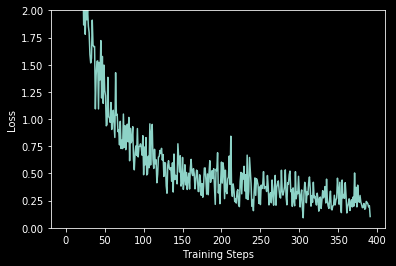

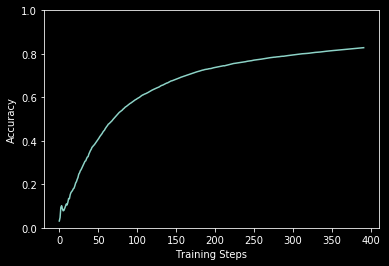

In [15]:
import matplotlib.pylab as plt
plt.style.use('dark_background')

plt.figure()
plt.ylabel("Loss")
plt.xlabel("Training Steps")
plt.ylim([0,2])
plt.plot(batch_stats.batch_losses)

plt.figure()
plt.ylabel("Accuracy")
plt.xlabel("Training Steps")
plt.ylim([0,1])
plt.plot(batch_stats.batch_acc)

In [16]:
label_names = sorted(image_data.class_indices.items(), key=lambda pair:pair[1])
label_names = np.array([key.title() for key, value in label_names])
label_names

array(['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'K', 'L', 'M', 'N',
       'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y'], dtype='<U1')

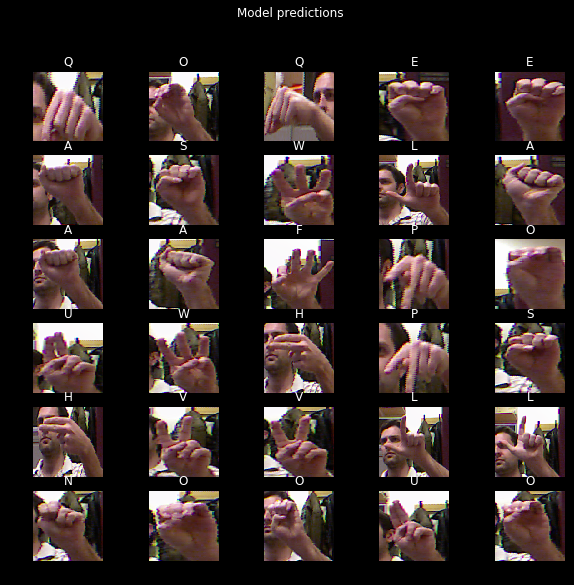

In [17]:
result_batch = model.predict(image_batch)

labels_batch = label_names[np.argmax(result_batch, axis=-1)]


plt.figure(figsize=(10,9))
for n in range(30):
  plt.subplot(6,5,n+1)
  plt.imshow(image_batch[n])
  plt.title(labels_batch[n])
  plt.axis('off')
_ = plt.suptitle("Model predictions")

model.save('sign_model.h5')

In [4]:
import cv2
import tensorflow as tf
from tensorflow.keras.models import load_model

cap = cv2.VideoCapture(0)

sess=tf.Session()
sess.run(tf.global_variables_initializer())

print('initialized')

font = cv2.FONT_HERSHEY_SIMPLEX

model = load_model('sign_model.h5')

while(True):
    # Capture frame-by-frame
    ret, frame = cap.read()

    ycrcb = cv2.cvtColor(frame, cv2.COLOR_BGR2YCrCb)
    if cv2.waitKey(1) & 0xFF == ord('q'):
        breaktf.Session

    lower_skin = np.array([0, 133, 77])
    upper_skin = np.array([255, 173, 127])

    mask = cv2.inRange(ycrcb, lower_skin, upper_skin)

    # Kernel matrices for morphological transformation
    kernel_square = np.ones((11, 11), np.uint8)
    kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))

    # Perform morphological transformations to filter out the background noise
    # Dilation increase skin color area
    # Erosion increase skin color area
    dilation = cv2.dilate(mask, kernel_ellipse, iterations=1)
    erosion = cv2.erode(dilation, kernel_square, iterations=1)
    dilation2 = cv2.dilate(erosion, kernel_ellipse, iterations=1)
    filtered = cv2.medianBlur(dilation2, 5)
    kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (8, 8))
    dilation2 = cv2.dilate(filtered, kernel_ellipse, iterations=1)
    kernel_ellipse = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (5, 5))
    dilation3 = cv2.dilate(filtered, kernel_ellipse, iterations=1)
    median = cv2.medianBlur(dilation2, 5)
    ret, thresh = cv2.threshold(median, 127, 255, 0)


    # Find contours of the filtered frame
    contours, hierarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Draw Contours
    # cv2.drawContours(frame, cnt, -1, (122,122,0), 3)
    # cv2.imshow('Dilation',median)

    # Find Max contour area (Assume that hand is in the frame)
    max_area = 100
    ci = 0
    for i in range(len(contours)):
        cnt = contours[i]
        area = cv2.contourArea(cnt)
        #stdev =
        if (area > max_area and True):
            max_area = area
            ci = i

        # Largest area contour
    cnts = contours[ci]

    border = 50
    x, y, w, h = cv2.boundingRect(cnts)
    cv2.rectangle(frame, (x-border, y-border), (x + w + border, y + h + border), (0, 255, 0), 2)

    crop_img = frame[y - border:y + h + border, x - border:x + w + border]

    img2 = cv2.resize(crop_img, dsize=(224, 224), interpolation=cv2.INTER_CUBIC)
    np_image_data = np.asarray(img2).astype('float32') / 255
    np_image = cv2.normalize(np_image_data.astype('float'), None, 0, 1, cv2.NORM_MINMAX)
    np_final = np.expand_dims(np_image_data, axis=0)
    print(np_final.shape)
    result = model.predict(np_final)
    print(result)
    label = label_names[np.argmax(result, axis=-1)]
    cv2.putText(frame, label, (cx, cy), font, 4, (0, 255, 0), 2, cv2.LINE_AA)
    
    cv2.imshow("test", frame)
    break


# When everything done, release the capture
cap.release()
cv2.destroyAllWindows()